# Exercise 2: Reduce data dimensions 


This notebook has been created by Julia Kukulies (julia.kukulies@gu.se) as a modified version from the exercise for GVN370 that has been created by Céline Heuzé. 

Today, you will again have to read data from a netcdf file and figure out which dimension is which, as in ex1. We will work with a3-D ERA5 file. If  you  have  not  downloaded  any,  use  the 3-D hourly sea  iceconcentration on  Canvas. Sea  ice concentration takes values between 0 and 1, or 0 and 100%, that indicates how much of the grid cell is covered by sea ice.

We are going to learn:

- to reduce your data to a specific date
- to produce daily and monthly means
- to reduce your data to a specific region (coordinate range)
- to produce area-averages
- to produce the sea ice area (sum over a region)

Basically, you are going to move from un-readable 3D data to way more manageable 1D or 2D metrics.The same methods are applicable to 4D data, but the files are much heavier.

Reduce your data to a specific date (or pressure, or longitude, or latitude). 

From last exercise, you should remember, how to:

- choose to the correct path to read the netcdf file with **xarray**
- display the metadata of the xaray dataset to know which variables you have and what their dimensions are
- extract a specific variable from the xarray dataset 


If you did this on the sea ice file, your variables are longitude, latitude, time and siconc(sea ice concentration).siconc dimensions are 1. longitude, 2. latitude, 3. time. time is in 'hours since 1900-01-01 00:00:00.0'.

# Reduce your data to a specific date 

As very briefly mentioned in ex1, you can use [**indexing and selecting**](http://xarray.pydata.org/en/stable/indexing.html) to subset your dataset. You can simply use indexing, as for a numpy array, but for this you would have to nee which index corresponds to the date you want to extract. An easier (and better way to avoid mistakes) is to use the function [**xarray.Dataset.sel**](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.sel.html). You should also know by now, that the date format we are dealing is the datetime format. Note, that this time we have **numpy.datetime64**, which is slightly different from the format from the climate model file. This can be confusing, but it is not too bad, because it can be used in the same way and also easily be converted from one format to the other. The fastest way of accessing the data at a certain date and time is thus to give the exact datetime value as an input argument in the search function. 

If you were to only select data on **23 March 2020 at 10:00**, the correct way of using the function is this: 



In [41]:
# basic library to handle datetime format is the datetime package
import datetime
# create a datetime object 
t= datetime.datetime(2020,3,23,10,0,0,0)
# use this as an input in search function (note, with method='nearest'
# you look for the closest value in case the exact value is not in the data)
siconc_mar = data.siconc.sel(time = t, method = 'nearest') 

In [42]:
siconc_mar

<xarray.DataArray 'siconc' (latitude: 721, longitude: 1440)>
[1038240 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 2020-03-23T10:00:00
Attributes:
    units:          (0 - 1)
    long_name:      Sea ice area fraction
    standard_name:  sea_ice_area_fraction

# Produce daily and monthly means 


Hourly data are heavy to manipulate, and, if you are interested in climate change, this high level of precision  will  only  hide  the  information  you’re  really  after.  Next  week,  we  will  use  more  elegant methods to filter the data. For now, let’s produce averages. Here, we want the monthly ERA5 file and not the hourly, since the hourly data only contained one single month and one single year. 



One way of performing such a calculation is, of course, to loop over the timesteps and then calculate the average (using **np.nanmean** or **np.nanmedian**) over x timesteps. However, it saves you programming and computation time to use existing functions for such operations! 

**xarray** provides an in-built function [xarray.DataArray.groupby](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.groupby.html) which can be used to first group a variable in the dataset by their attributes (e.g. year or month via the time dimension) and then compute the mean over the group: 

In [53]:
annual_means = data.sst.groupby('time.year').mean('time')  

In [57]:
# same for monthly 
monthly_means = data.sst.groupby('time.month').mean('time')  

A good idea is to save the new dataset as an xarray (you know how to do it now)! 

# Reduce your data to a specific region 

There are two ways to select a specific region, depending on whether you are working with gridded data (as is our case here) or with ungridded, scattered data (typical in-situ observations).

If your data are **regularly gridded**, you will in general have one dimension array for the longitudes and one dimension array for the latitudes, and these two arrays have different lengths. If instead you have a 2D matrix with irregular spacings between each longitude and/or latitude, you have data on an irregular grid, or so-called **scattered data**. That is very common with regional climate model data or ocean climate model data, but also with in-situ observations. The good thing is that it does not make any difference for this task with Python, but you may keep that in mind for other operations. 


We are going to select the **Barents Sea: longitude 20-55°E, latitude 66-80°N**. As above, we use [**xarray.Dataset.sel**](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.sel.html):

In [3]:
barent_sea= data.sel(latitude = (data.latitude > 66) & (data.latitude > 80) , longitude = (data.longitude > 20) & (data.longitude > 55) )


An alternative way (and sometimes preferred when you want to keep the same dimensions) is to create a mask and set the other values to NaN:

In [4]:

barent_sea = data.where((data.siconc.latitude > 66) & (data.siconc.latitude < 80) & (data.siconc.longitude > 20)& (data.siconc.longitude < 55))
    

# Produce area-averages 

Back to easier things.The same way that you can average over time, you can average over space. The good thing is that [numpy.nanmean](https://numpy.org/doc/stable/reference/generated/numpy.nanmean.html) allows you two directly average over multiple dimensions: 


In [4]:
barent_sea.dims

Frozen(SortedKeysDict({'longitude': 1440, 'latitude': 721, 'time': 744}))

As you can see, we want to average over the first and second dimension, in order to get the timeseries for the region of the Barent Sea. 

In [ ]:
fldmean = np.nanmean(barent_sea.siconc.values, axis=(0, 1)) 

In [ ]:
# alternatively you can also flatten the array and calculate the mean over 1D:
fldmean = np.nanmean(barent_sea.siconc.values.flatten())

In [ ]:
# the same can be done to compute the median instead of mean 
fldmean = np.nanmedian(barent_sea.siconc.values.flatten())

If  you  work  with  large  regions  and/or  high  latitudes,  you should  not  average  brutally  like  this  but instead produce “area-weighted averages”. That is, give a weight to each position’s value  based on the area of the grid cell at that position divided by the regions total area. Why that? Because the area of each lat-lon grid box is dependent on latitude and decreases substantially towards the poles. This is, however ,beyond the scope of this course, but think of how you would do it, and in particular, how you would calculate the areas.

## Sum over an area (little less easy)

Instead of taking the average concentration over a region, it is way more common to read about “how many km$^2$ of sea ice” this region contains. That’s typically called the sea ice extent; check for example the [daily sea ice extent graphs produced by NSIDC](http://nsidc.org/arcticseaicenews/). The extent requires that you know two things: 


- how to select the points that have a concentration larger than a specific value (15%)

- the area of each grid cell (see above).




1. For the first step, we can simply create a mask using the function [**xarray.Dataset.where**](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.where.html) again, this time with a condition for the variable value rather than for the dimensions : 

In [36]:
sea_ice_mask = data.where(data.siconc > 0.15)

An alternative way is to use [fancy indexing](https://jakevdp.github.io/PythonDataScienceHandbook/02.07-fancy-indexing.html):

In [38]:
sea_ice_mask.siconc.data[sea_ice_mask.siconc.data < 0.15] = np.nan

2. IF you are keen on knowing how you calculate an area-average, the you can have a look [here](http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html). But for simplicity, you can use the file called **global_area.nc** on Canvas which provides the area in km$^2$ for each grid cell on the ERA5 grid. This is how the file should look like (see that the area is the same on each latitude band but increases towards the equator/decreases towards the poles):


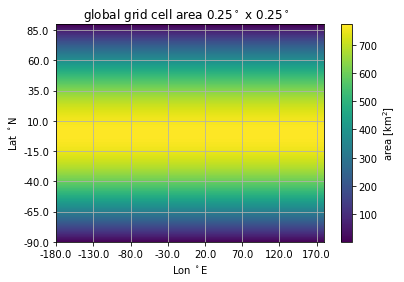

In [74]:
plt.pcolormesh(area/1000000)
plt.colorbar(label= 'area [km$^2$]')
plt.title('global grid cell area 0.25$^\circ$ x 0.25$^\circ$  ')
plt.grid('on')
plt.xlabel('Lon $^\circ$E')
plt.ylabel('Lat $^\circ$N')
plt.yticks(np.arange(0,720)[::100], lats[::100])
plt.xticks(np.arange(0,1440)[::200], lons[::200])
plt.show()


3. Subset the region for the area to the same horizontal extent as you sea ice concentration. For arithmetic operations, it is always the easiest to have the arrays of interest in the same dimensions. If your time dimensions differ, it is not possible to just add or multiply two arrays. However, you can multiply a 3D array with a 2D array of which the two dimensions correspond to two dimensions of the 3D array. If you are confused now, you may read more on [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) of numpy arrays. Otherwise, just accept and continue. 


4. multiply your sea ice extent with the area in km$^2$ for the ERA5 grid:

In [ ]:
siextent = sea_ice_mask* area_ERA5